In [1]:
import pandas as pd
df = pd.read_excel('data_process_all.xlsx')

# 计算文本加权情感强度

In [2]:
#文本加权情感强度计算公式为：整体情感极性*K（是否为长文本）*（分词情感强度绝对值+emoji数量*3）/分词长度
#其中，整体情感极性由百度API提供；长文本权重为1.5，短文本权重为1
import numpy as np
df['weighted_score']=0
for i in range(len(df)):
    try:
        num_emoji=len(df['weibo_emoji'][i].split(","))
    except:
        num_emoji=0
    length=df['length'][i]
    emo_score=abs(df['emo_score'][i])
    if df['isLongText'][i]:
        k=1.5
    else:
        k=1
    if df['baidu_pm'][i]=="正向":
        emo=1
    else:
        emo=-1
    df['weighted_score'][i]=emo*k*(emo_score+num_emoji*3)/length
df['weighted_score']=df['weighted_score'].fillna(value=0)
df['weighted_score'][np.isinf(df['weighted_score'])] = 0

C:\Users\Jingyao Zhu\AppData\Local\Temp\ipykernel_28472\294634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weighted_score'][i]=emo*k*(emo_score+num_emoji*3)/length
C:\Users\Jingyao Zhu\AppData\Local\Temp\ipykernel_28472\294634369.py:20: RuntimeWarning: invalid value encountered in double_scalars
  df['weighted_score'][i]=emo*k*(emo_score+num_emoji*3)/length
C:\Users\Jingyao Zhu\AppData\Local\Temp\ipykernel_28472\294634369.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  df['weighted_score'][i]=emo*k*(emo_score+num_emoji*3)/length
C:\Users\Jingyao Zhu\AppData\Local\Temp\ipykernel_28472\294634369.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

# 微博话题强度计算

In [3]:
#情感强度第一定律公式μ=K*log(1+△p)，其中K与事件
#价值率高差计算公式：△p=(Ci-Cmin)/(Cmax-Cmin),其中i为时间戳，C为时间戳中转评赞总和
import datetime
#数据是从22年2月到23年四月底，其中由于23.4.7官方发布相关消息，讨论度变化较大，故取前后一段时间舆论强度变化作为示例
# 在这里修改始末时间参数
START=datetime.datetime.strptime("2023-4-7 11:30:00", '%Y-%m-%d %H:%M:%S')
END=datetime.datetime.strptime("2023-4-7 21:30:00", '%Y-%m-%d %H:%M:%S')

#划分时间戳
start=[]
end=[]
h=1/6  # 采样频率，比如2小时采样一次（单位：hr）
begin=START
while begin<END:
    start.append(begin)
    end.append(begin+datetime.timedelta(hours=h))
    begin=begin+datetime.timedelta(hours=h)

C=[0 for i in range(len(start))]
Stext=[0 for i in range(len(start))]
for i in range(len(df)):
    time=df['created_at'][i]
    count=df['comments_count'][i]+df['attitudes_count'][i]+df['reposts_count'][i]+1 #计数=转赞评+文本
    score=df['weighted_score'][i]
    for j in range(len(start)):
        if time>=start[j] and time<end[j]:
            C[j]+=count
            Stext[j]+=score
Stopic=[0 for i in range(len(start))]
for j in range(len(C)):
    p=(C[j]-min(C))/(max(C)-min(C))
    Stopic[j]=2*np.log(1+p)

# 综合情感计算及舆情变化趋势检测
- start: 每个时间窗口的起始时间
- SE: 每个时间窗口上的综合情感得分

In [4]:
SE=[0 for i in range(len(start))]
for i in range(len(C)):
    SE[i]=abs(Stext[i]*Stopic[i]/2)

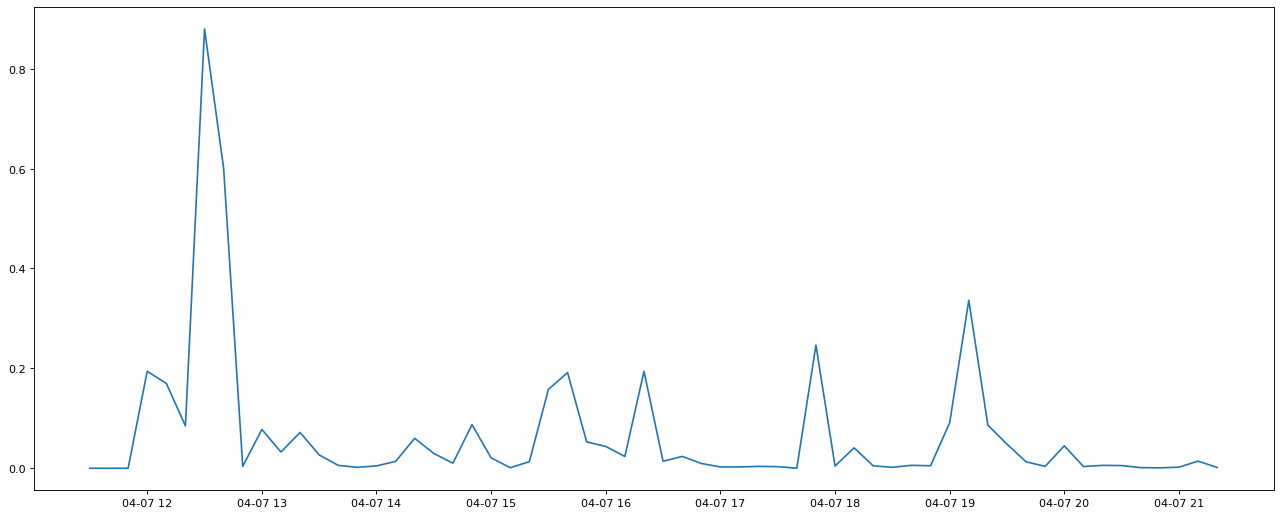

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8),dpi=80)    
plt.plot(start,SE)

In [6]:
#舆情变化率近似于(SEt+1-SEt)/T
#其中T为时间间隔，即一个时间戳长度
y=[(SE[i+1]-SE[i])/h for i in range(len(SE)-1)]

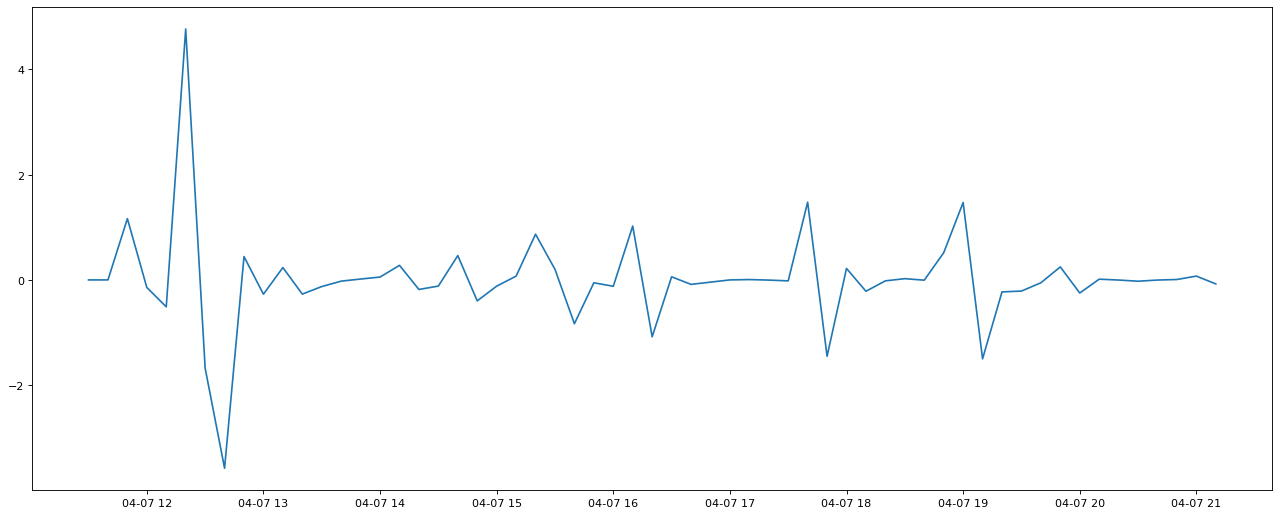

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8),dpi=80)    
plt.plot(start[:len(start)-1],y)

# time series forecast
- 目标：预测SE的走势
- 方法：Elman、LSTM (本质上也是Elman)、...
- 目前已经预见的问题：
    - 只能在一个很小的时间窗里预测（如几天），可以理解为事件触发的舆情变化
- 可以改变的一些参数：
    - 选取的时间窗起止时间
    - 采样频率（h）
- 模型参考：https://zhuanlan.zhihu.com/p/149769210
    - 基于神经网络的微博舆情预测方法：https://kns.cnki.net/KXReader/Detail?invoice=NtKR6N68jIPsBmoAuxaNDWnRxtq4HiQGmv9v%2BBTcWcWm8OpSNimPhrHEIOwauWbf8ytlVOGWNg21JPMEJNQkKhJA09QSoHsYIF9k30JIjV6YjWDIan1MXC6DNvJKrOrchFn5IZMpieV77lvYuqiyS9jnDCKBLjoO4qcLBcyKqN8%3D&DBCODE=CJFD&FileName=HNLG201609007&TABLEName=cjfdlast2016&nonce=D6DD2DD9863C4350A7430B3001624C53&TIMESTAMP=1684082854835&uid=
        - Elman神经网络：
            - https://zhuanlan.zhihu.com/p/35106766
            - https://blog.csdn.net/itnerd/article/details/103265170
            - https://juejin.cn/post/6844903703804117000
            - neurolab official doc: https://pythonhosted.org/neurolab/ex_newelm.html
        - LSTM: https://blog.csdn.net/zbzcDZF/article/details/125992091?utm_medium=distribute.pc_relevant.none-task-blog-2~default~baidujs_baidulandingword~default-4-125992091-blog-103262346.235^v36^pc_relevant_default_base3&spm=1001.2101.3001.4242.3&utm_relevant_index=5

## LSTM （其他的我也乱七八糟试过一点都不太行，只能说这个时间序列真不太好预测hhh）
- pre时可以考虑改变几个参数作图看看
    - time scope
    - 采样频率
    - LOOKBACK的时间步数
    - HIDDEN_SIZE说实话没啥好改的，因为大不了

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
from torch import nn
from torch.autograd import Variable
torch.set_default_tensor_type(torch.DoubleTensor)

In [9]:
# LOOBACK: 以前的时间步数用作输入变量来预测下一个时间步
LOOKBACK = 2

#数据预处理
dataset = SE
train_size = int(len(dataset) * 0.7)
test_size = len(dataset)-train_size
# 一刀切分成train, test
dataset_train = dataset[:-test_size]
dataset_test = dataset[-test_size:]

# 标准化
# max_value = np.max(dataset)
# min_value = np.min(dataset)
# scalar = max_value-min_value
# dataset = list(map(lambda x: x/scalar, dataset))  # 将数据标准化到0~1之间


def create_dataset(dataset, look_back=LOOKBACK):  
    data_X, data_y=[], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i+look_back)]  
        data_X.append(a)
        data_y.append(dataset[i+look_back])  
    return np.array(data_X), np.array(data_y)  


train_X, train_y = create_dataset(dataset_train)

 
train_X = train_X.reshape(-1,1,LOOKBACK)  # 第一个维度为batch
train_y = train_y.reshape(-1,1,1)


train_X = torch.from_numpy(train_X)  # ndarray转化成tensor
train_y = torch.from_numpy(train_y)



In [10]:
# 创建lstm类
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg,self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) 
        self.reg = nn.Linear(hidden_size, output_size)
        
    def forward(self,x):   
        x, _ = self.rnn(x)
        s,b,h = x.shape
        x = x.view(s*b, h)  # 输出变为（s*b）*h的二维
        x = self.reg(x)
        x = x.view(s,b,-1)  # 卷积的输出从外到里的维数为s,b,一列
        return x

# 数据点有限且结构简单，只用3个神经元够够的了
HIDDEN_SIZE = 3
net = lstm_reg(LOOKBACK, HIDDEN_SIZE) 

# 定义一堆训练参数
loss_fn = nn.MSELoss()  
optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)


# 开始训练
for epoch in range(3000):
    var_X = Variable(train_X)  # 转换为带梯度的Variable
    var_y = Variable(train_y)
    var_X = var_X.to(torch.float64)
 
    out = net(var_X)
    loss = loss_fn(out, var_y)
 
    optimizer.zero_grad()  # 梯度置零
    loss.backward()  # 计算梯度
    optimizer.step()  # 更新参数
    if (epoch + 1) % 100 == 0:
        print('Epoch: {}, Loss:{:.5f}'.format(epoch+1, loss.item()))

# 保存训练文件
torch.save(net.state_dict(), 'net_params.pkl')

Epoch: 100, Loss:0.03388
Epoch: 200, Loss:0.02919
Epoch: 300, Loss:0.02863
Epoch: 400, Loss:0.02811
Epoch: 500, Loss:0.02756
Epoch: 600, Loss:0.02692
Epoch: 700, Loss:0.02599
Epoch: 800, Loss:0.02439
Epoch: 900, Loss:0.01790
Epoch: 1000, Loss:0.01313
Epoch: 1100, Loss:0.01073
Epoch: 1200, Loss:0.00901
Epoch: 1300, Loss:0.00770
Epoch: 1400, Loss:0.00697
Epoch: 1500, Loss:0.00698
Epoch: 1600, Loss:0.00518
Epoch: 1700, Loss:0.00424
Epoch: 1800, Loss:0.00389
Epoch: 1900, Loss:0.00277
Epoch: 2000, Loss:0.00243
Epoch: 2100, Loss:0.00231
Epoch: 2200, Loss:0.00192
Epoch: 2300, Loss:0.00179
Epoch: 2400, Loss:0.00170
Epoch: 2500, Loss:0.00193
Epoch: 2600, Loss:0.00157
Epoch: 2700, Loss:0.00229
Epoch: 2800, Loss:0.00156
Epoch: 2900, Loss:0.00146
Epoch: 3000, Loss:0.00155


In [11]:
# 在测试集上Forecast
# 采用rolling的形式
# history是列表形式
def forecast_h_steps(model, history, LOOKBACK, h):
    # 第一个data_X就是history的最后几个观测
    data_X = history[-LOOKBACK:]
    
    
    # 新建一个列表存储forecasts
    forecasts = []
    
    for i in range(h):
        
        # 处理成tensor
        data_X = np.array(data_X).reshape(-1, 1, LOOKBACK)
        data_X = torch.from_numpy(data_X)
        data_X = Variable(data_X)
        
        # 预测下一个点
        new_forecast = model.forward(data_X).item()
        
        # 更新入forecasts
        forecasts.append(new_forecast)
        
        # 更新data_X: 窗口向后滑动一步，加上新的forecast
        data_X = list(data_X.view(-1).data.numpy())
        data_X = data_X[-(LOOKBACK-1):] + [new_forecast]
    
        
    return forecasts

In [12]:
# 加载模型并导入参数
net = lstm_reg(input_size=LOOKBACK, hidden_size=HIDDEN_SIZE)
net.load_state_dict(torch.load('net_params.pkl')) 

# train部分：拟合情况
train_X = train_X.reshape(-1, 1, LOOKBACK)
fitted_values = net.forward(train_X)
fitted_values = fitted_values.view(-1).data.numpy()

# test部分：forecast情况
forecasts = forecast_h_steps(net, dataset_train, LOOKBACK, h=test_size)

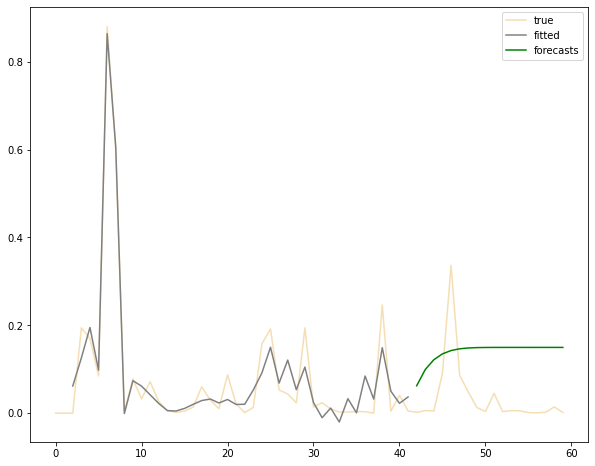

In [14]:
# 画图
plt.figure(figsize=(10, 8))
fitted_idx = [i for i in range(LOOKBACK, train_size)]
forecasts_idx = [i for i in range(train_size, train_size + test_size)]
plt.plot(dataset, 'wheat', label = 'true')
plt.plot(fitted_idx, fitted_values, 'grey', label = 'fitted')
plt.plot(forecasts_idx, forecasts, 'green', label = 'forecasts')
plt.legend()

## 这结果总之蛮抽象的，但它竟然真的预测出来舆情会有个抬升...离谱